In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from sklearn.metrics import accuracy_score, v_measure_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from torchvision.datasets import MNIST

from src.utils import create_data_loader, get_samples_numpy

sns.set()

In [2]:
data_path = Path("data")
df = pd.DataFrame()

for folder in data_path.iterdir():
    tmp = pd.DataFrame()
    for file in filter(lambda x: ".csv" in str(x), folder.iterdir()):
        tmp = pd.concat([
            tmp,
            pd.read_csv(file)
        ], axis=0, ignore_index=True)
        
    tmp["type_ae"] = folder.name
    df = pd.concat([
        df,
        tmp
    ], axis=0, ignore_index=True)
    
df.type_ae = df.type_ae.replace("tied_ort_ae", "tied_orthogonal_ae")

In [3]:
df.eval_test.describe()

count     22680.000000
mean          7.921581
std         764.829679
min           0.004562
25%           0.010251
50%           0.015406
75%           0.023697
max      105226.265625
Name: eval_test, dtype: float64

In [4]:
#Remove bad optimizations
df = df[df.eval_test <= df.eval_test.quantile(0.99)]

### Baseline (*source space*)

In [5]:
data_path = "../pytorch_data/"
batch_size = 256
baseline = {}

transform = transforms.Compose([transforms.ToTensor()])
dtrain = create_data_loader(data_path, MNIST, transform, batch_size, True)
dtest = create_data_loader(data_path, MNIST, transform, batch_size, False)

x_train = get_samples_numpy(dtrain)
x_train = x_train.reshape(-1, np.prod(x_train.shape[1:]))
y_train = dtrain.dataset.targets.numpy()

x_test = get_samples_numpy(dtest)
x_test = x_test.reshape(-1, np.prod(x_test.shape[1:]))
y_test = dtest.dataset.targets.numpy()

knn = KNeighborsClassifier(n_neighbors=1, algorithm='brute').fit(x_train, y_train)
kmeans = KMeans(n_clusters=len(np.unique(y_train))).fit(x_train)
knn_pred = knn.predict(x_test)
km_pred = kmeans.predict(x_test)

baseline["accuracy"] = accuracy_score(y_test, knn_pred)
baseline["v_measure"] = v_measure_score(y_test, km_pred)

baseline

{'accuracy': 0.9691, 'v_measure': 0.5090471986862436}

### Results of experiments

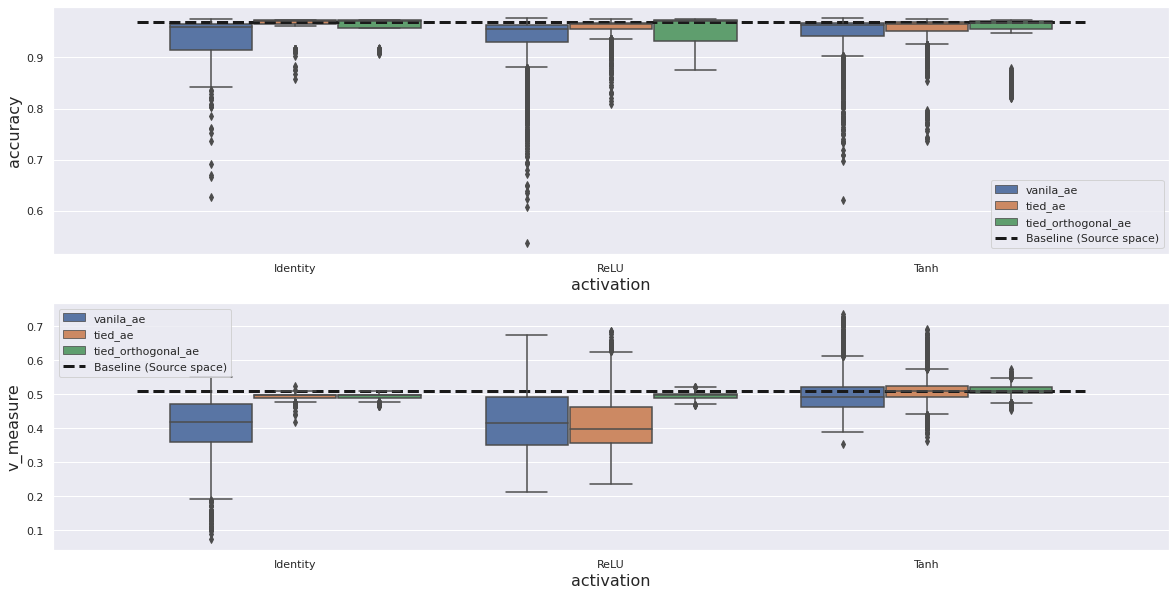

In [6]:
f, axes = plt.subplots(2, 1, figsize=(20,10))
metrics = ["accuracy", "v_measure"]
for metric, ax in zip(metrics, axes):
    sns.boxplot(
        x="activation", 
        y=metric,
        hue="type_ae",
        order=["Identity", "ReLU", "Tanh"],
        hue_order=["vanila_ae", "tied_ae", "tied_orthogonal_ae"],
        data=df,
        ax=ax
    )
    ax.set_ylabel(ax.get_ylabel(), fontdict={"size":16})
    ax.set_xlabel(ax.get_xlabel(), fontdict={"size":16})
    ax.hlines(baseline[metric], *ax.get_xlim(), color="k", ls="dashed", lw=3, label="Baseline (Source space)")
    ax.legend()
f.savefig("Images/metrics_vs_activation.png")

In [7]:
def plot_scatter(data_frame, cols, title, ax, corr_func):
    ax = sns.scatterplot(x=cols[0], y=cols[1], data=data_frame, label="Latent space", ax=ax)
    ax.set_xlabel(f"$x$ ({cols[0]})", fontdict={"size":20})
    ax.set_ylabel(f"$y$ ({cols[1]})", fontdict={"size":20})
    corr, _ = corr_func(data_frame[cols[0]], data_frame[cols[1]])
    ax.set_title(title + f"\n$C_{{xy}}$ = {corr:.3f}", fontdict={"size":16})
    if data_frame[cols[0]].nunique() < 10:
        ax.set_xticks(data_frame[cols[0]].unique())
    return ax
    

def scatter_plots(data_frame, cols, **kwargs):
    types_ae = ["vanila_ae", "tied_ae", "tied_orthogonal_ae"]
    activations = data_frame.activation.unique()
    fig, axes = plt.subplots(
        len(types_ae), 
        len(activations), 
        figsize=(30,15), 
        sharex="all", 
        sharey="row", 
        gridspec_kw={"hspace":0.5})
    activations = sorted(data_frame.activation.unique())

    baseline = kwargs.pop("baseline", None)
    for row, type_ae in zip(axes, types_ae):
        for ax, activation in zip(row, activations):
            tmp = data_frame[(data_frame.type_ae == type_ae) & (data_frame.activation == activation)]
            title = f"{type_ae[:-3].capitalize()} autoencoder\n{activation} activation"
            ax = plot_scatter(tmp, cols, title, ax, **kwargs)
            if baseline:
                ax.hlines(baseline[cols[1]], *ax.get_xlim(), color="k", ls="dashed", label="Baseline (Source space)")
            ax.legend()
    return fig

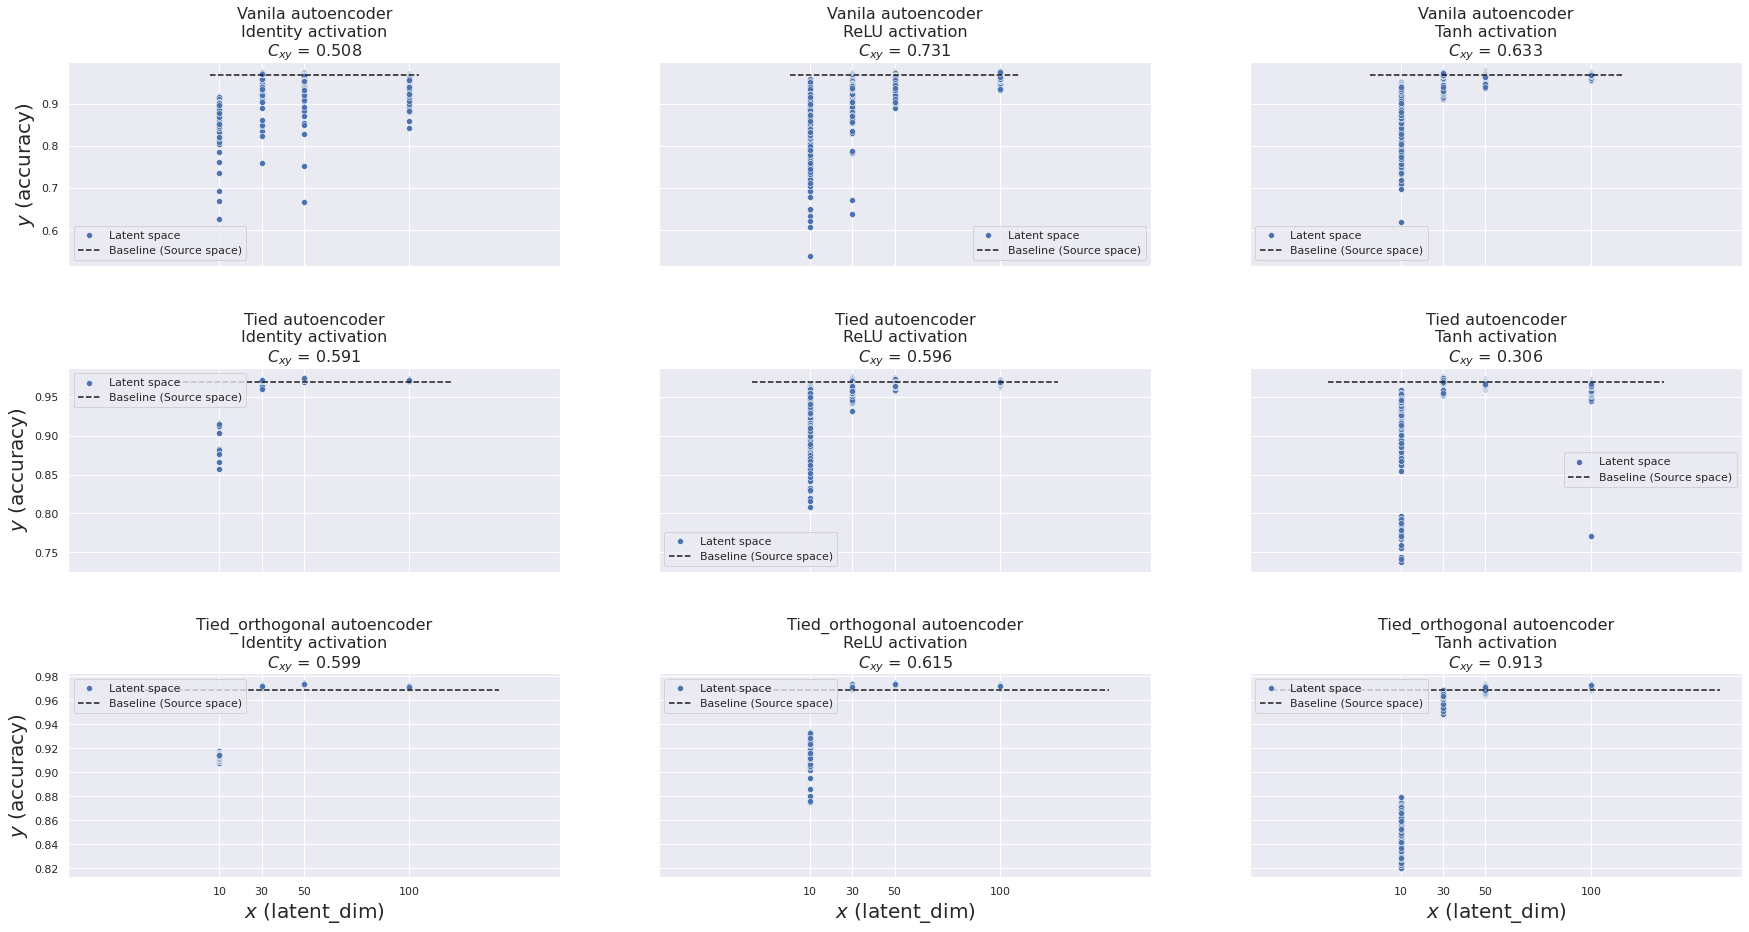

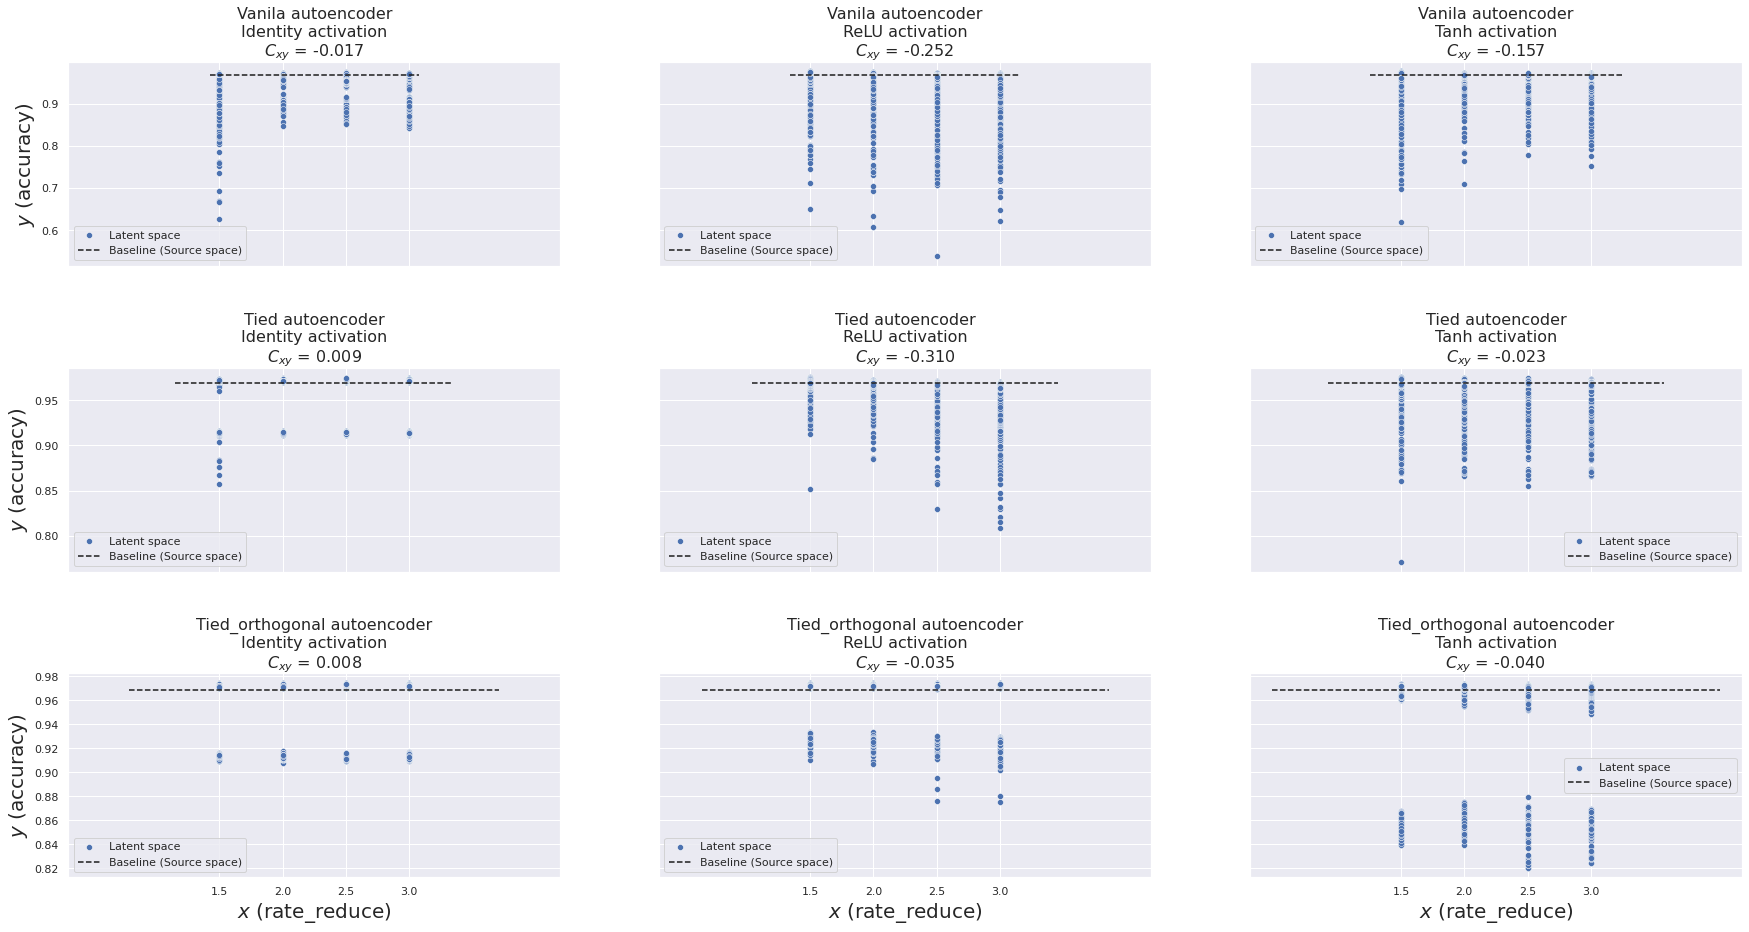

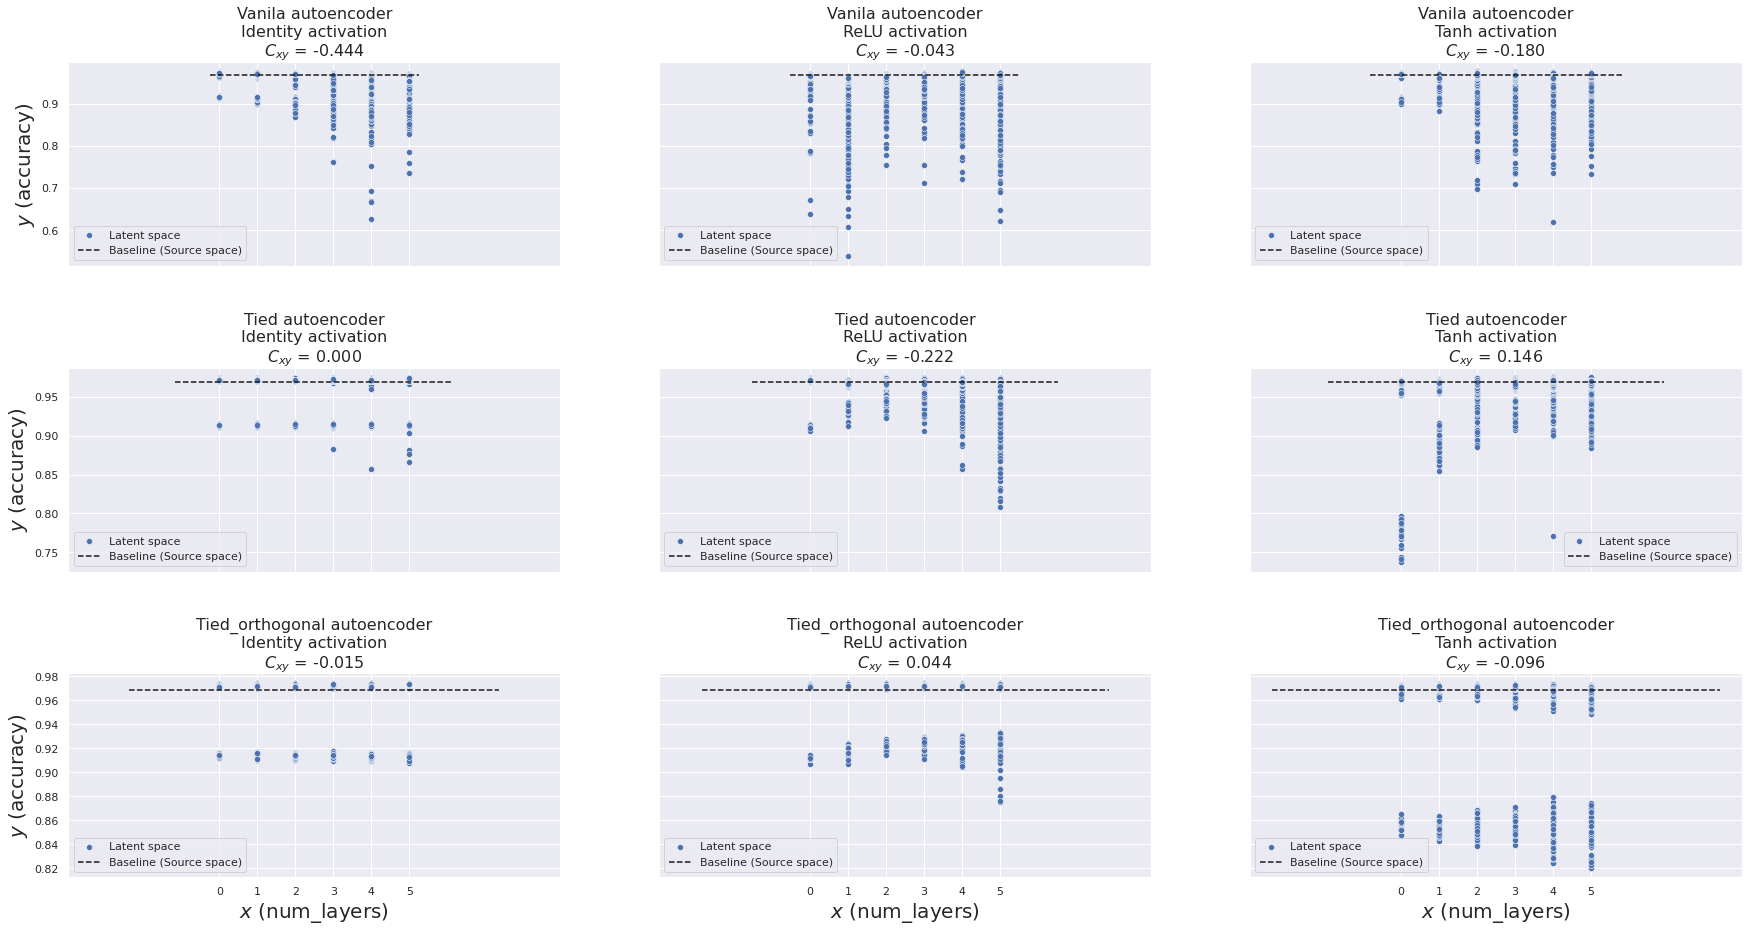

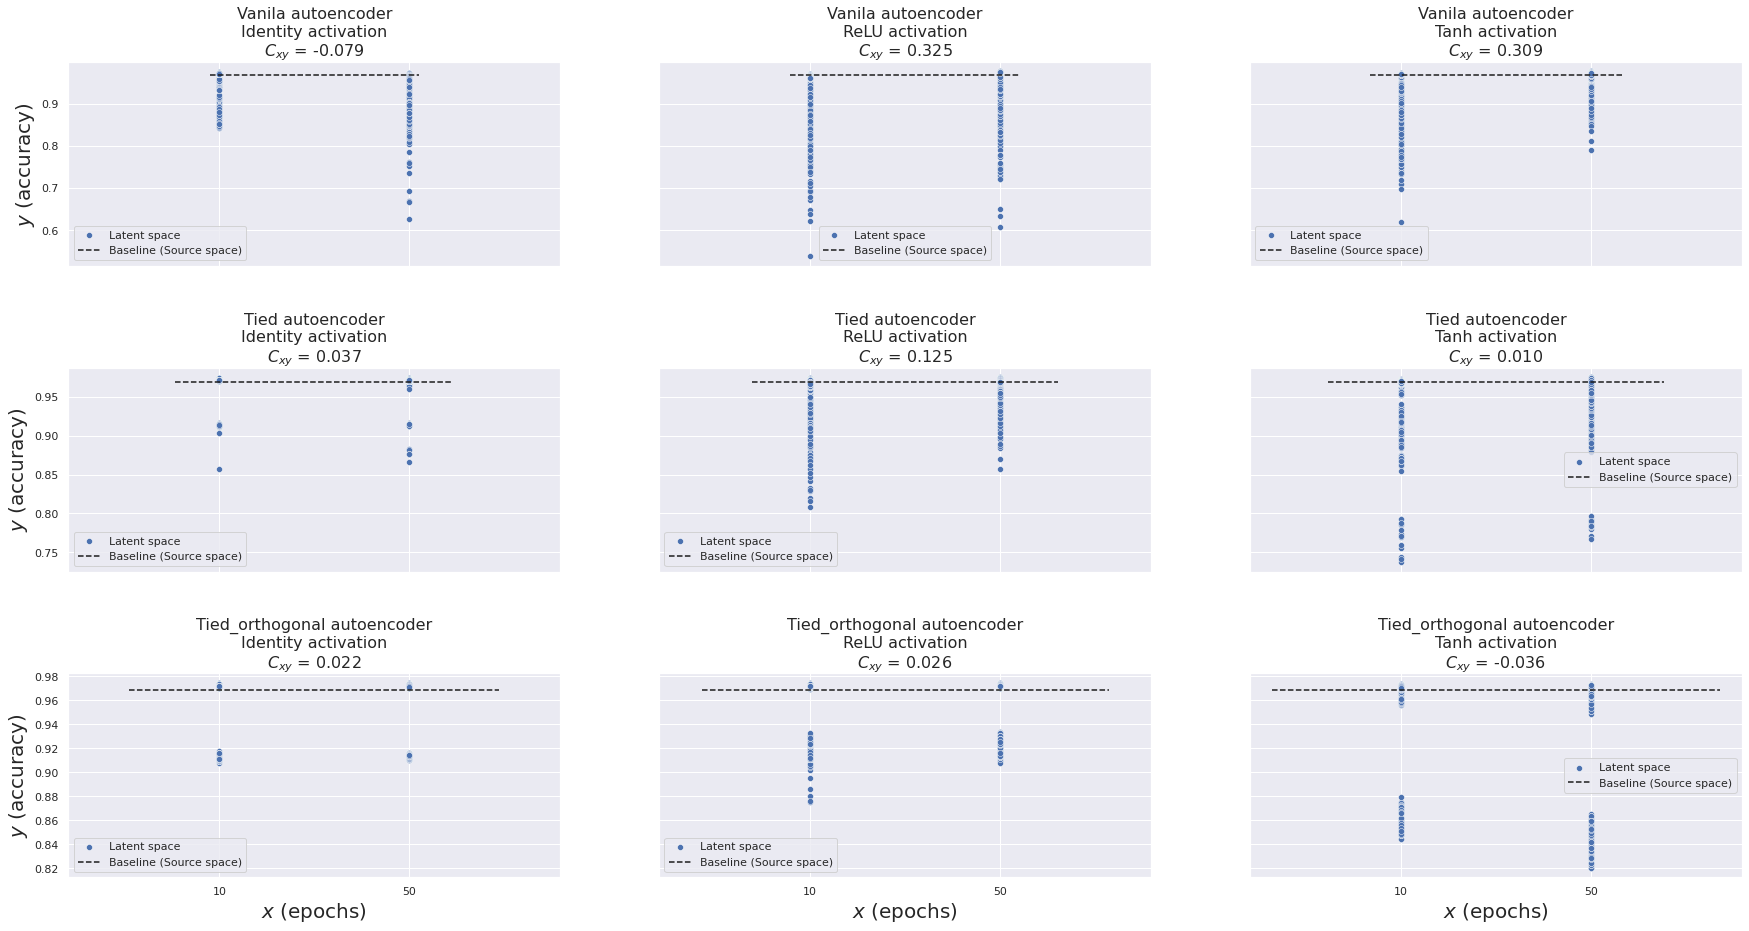

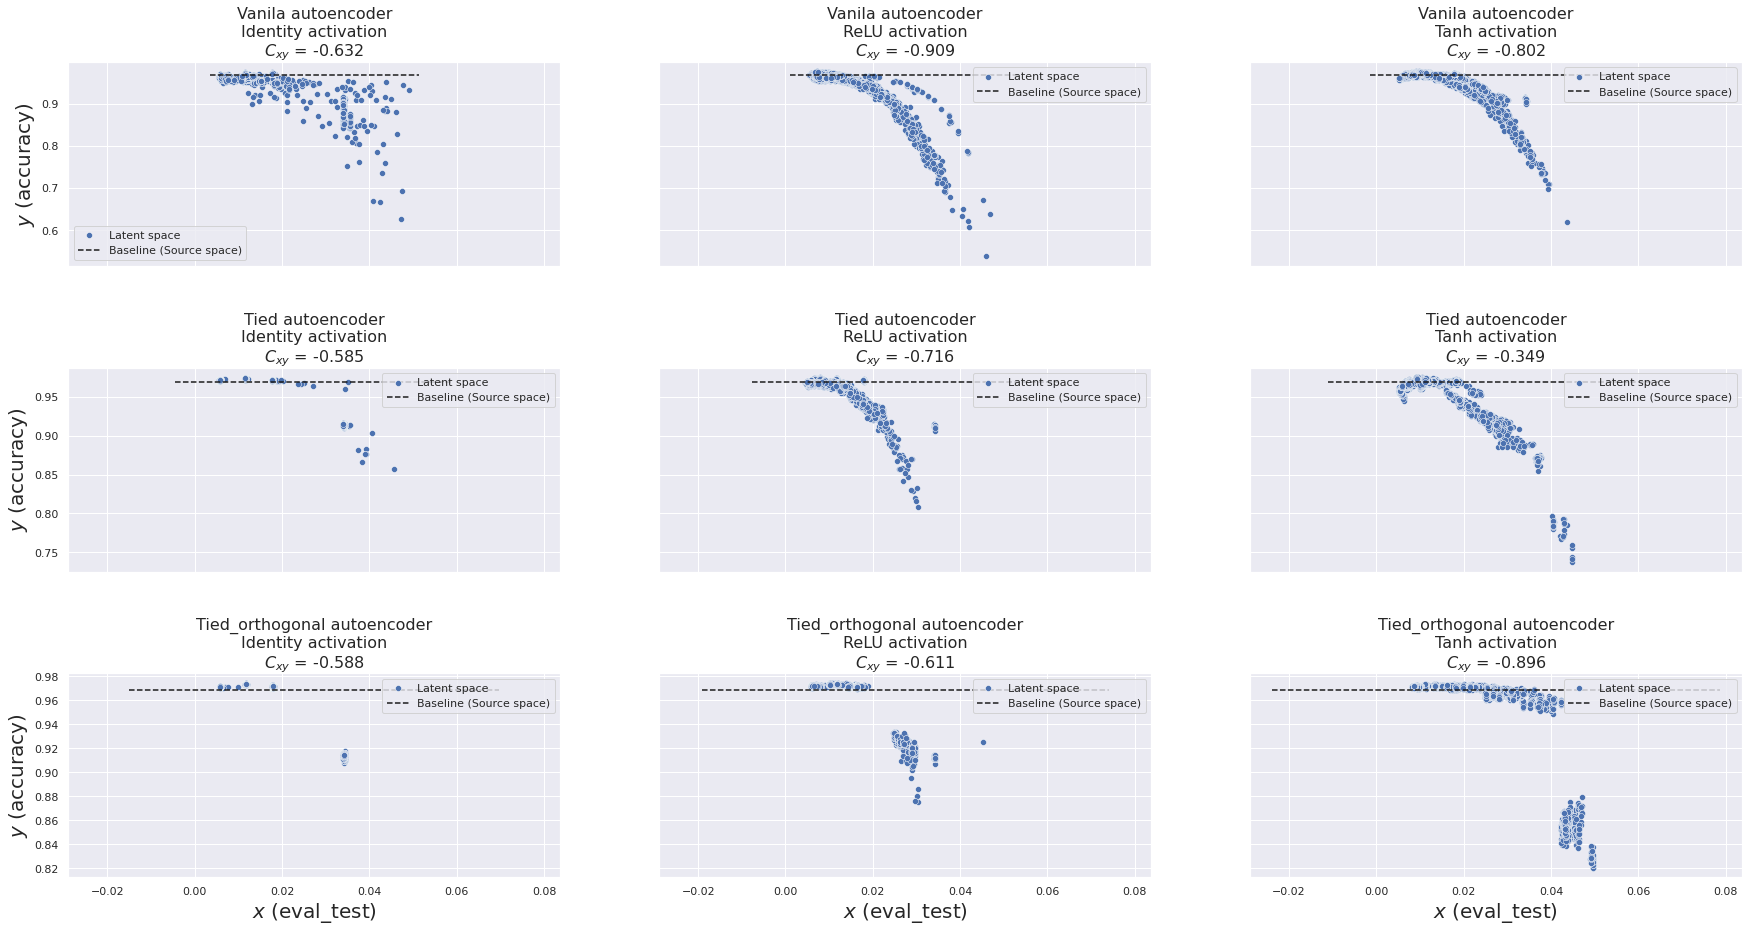

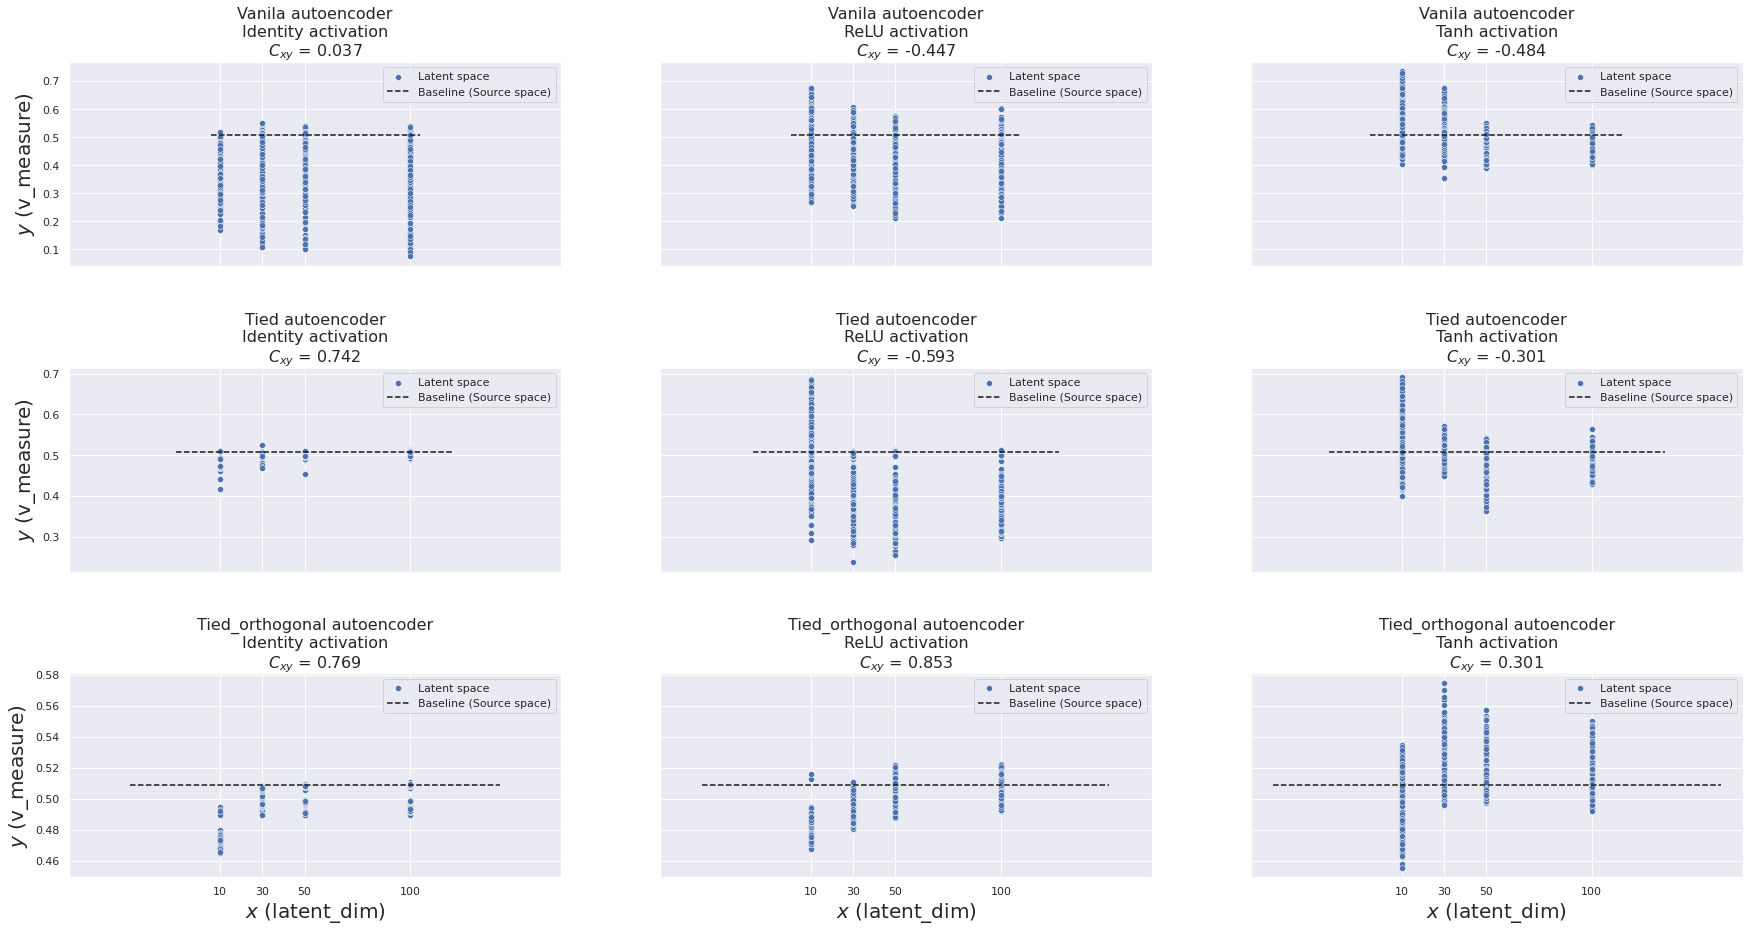

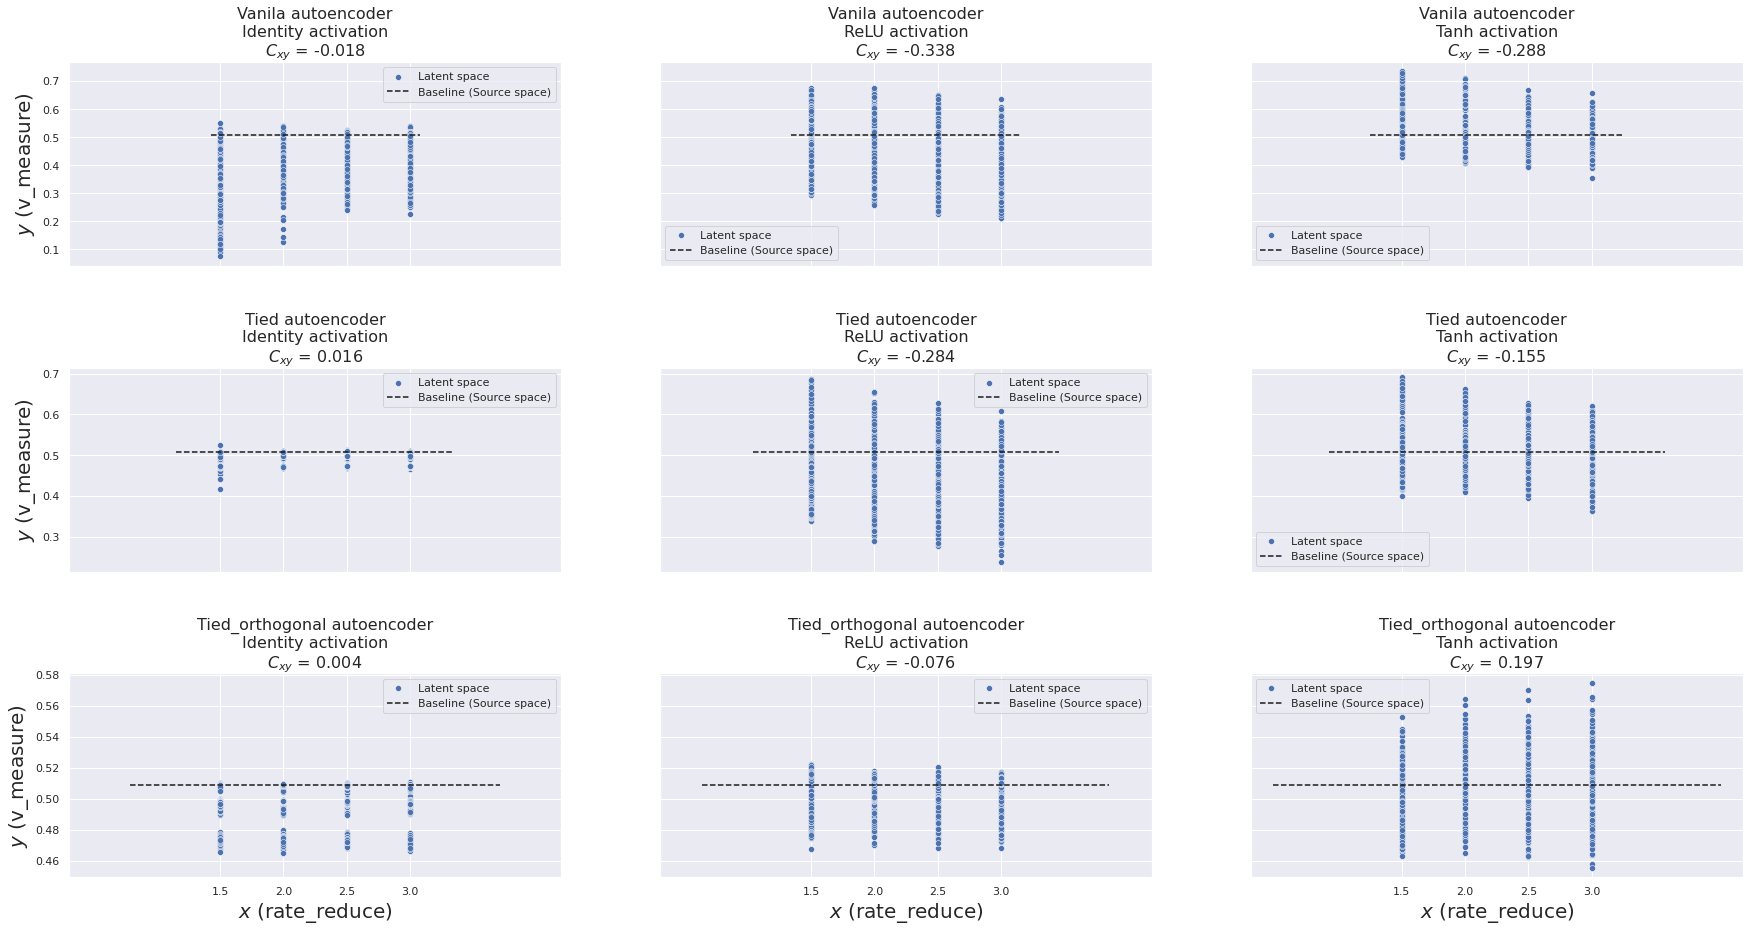

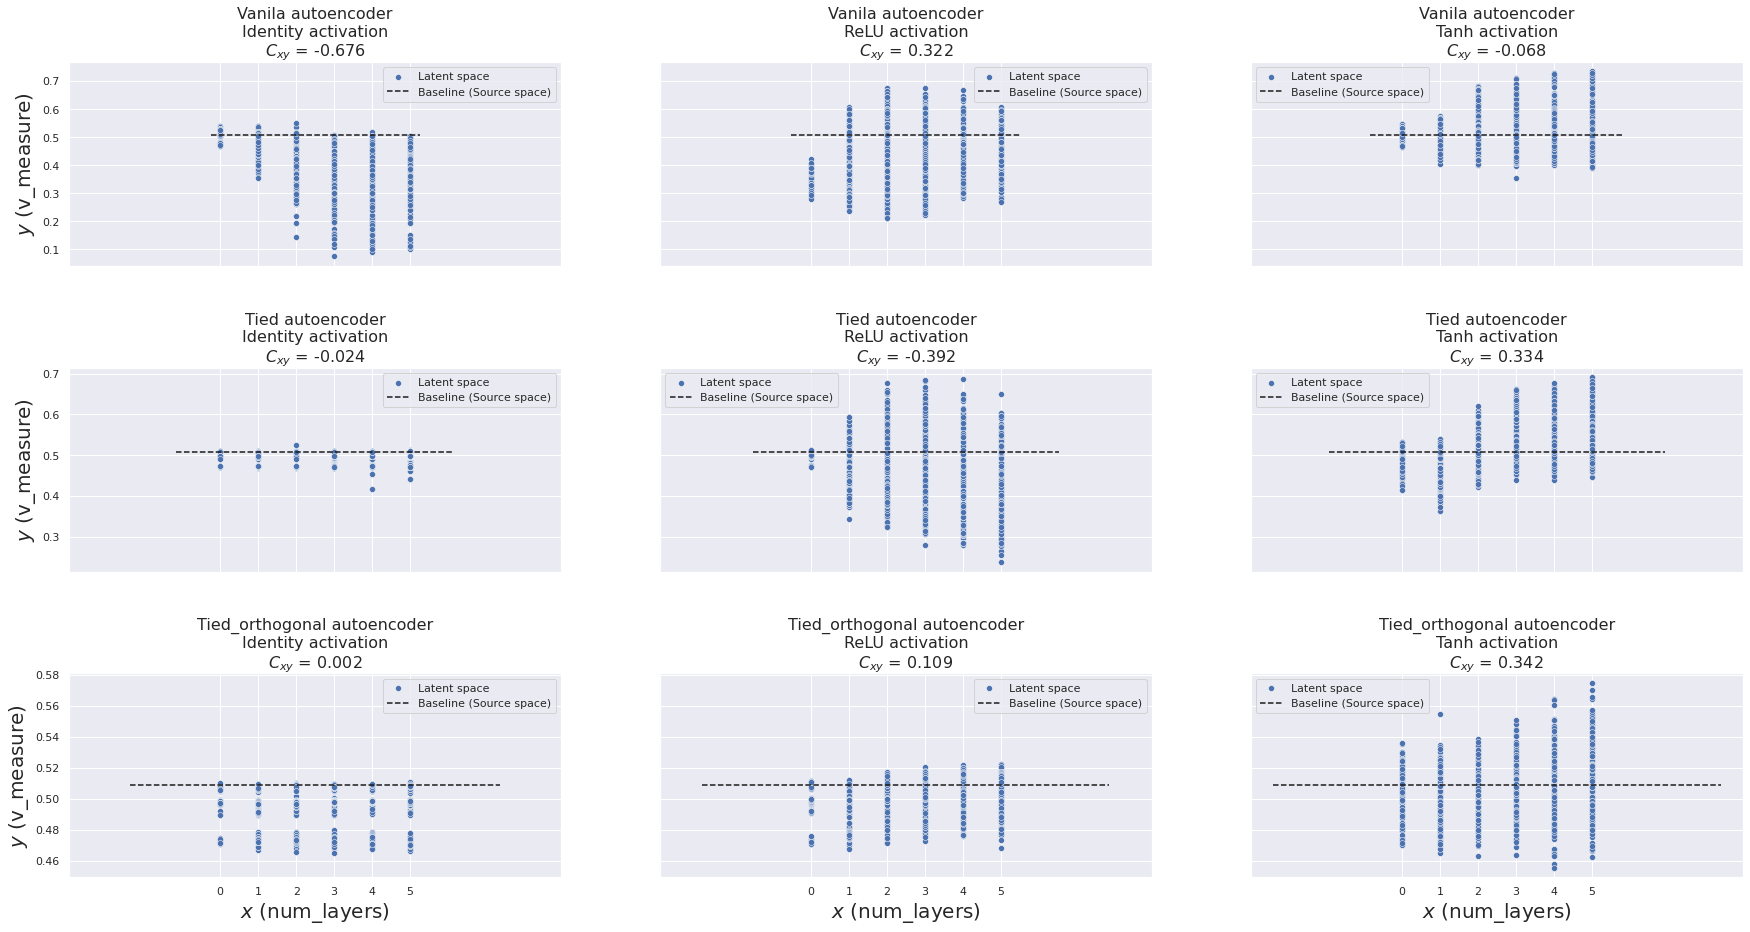

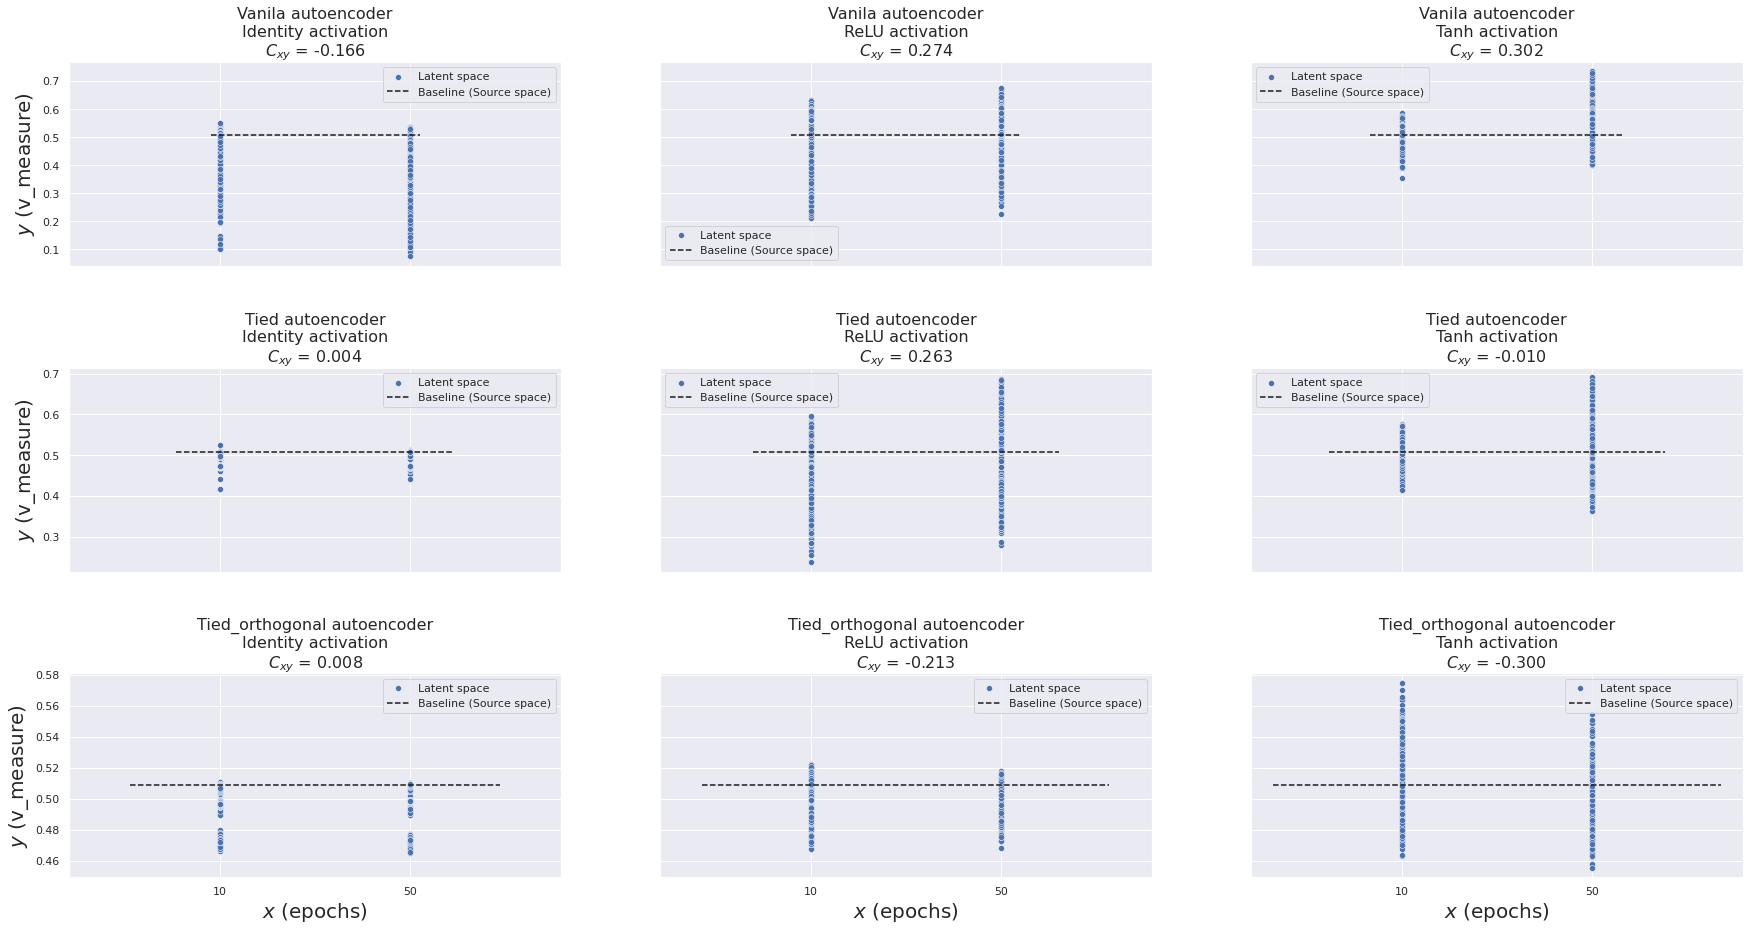

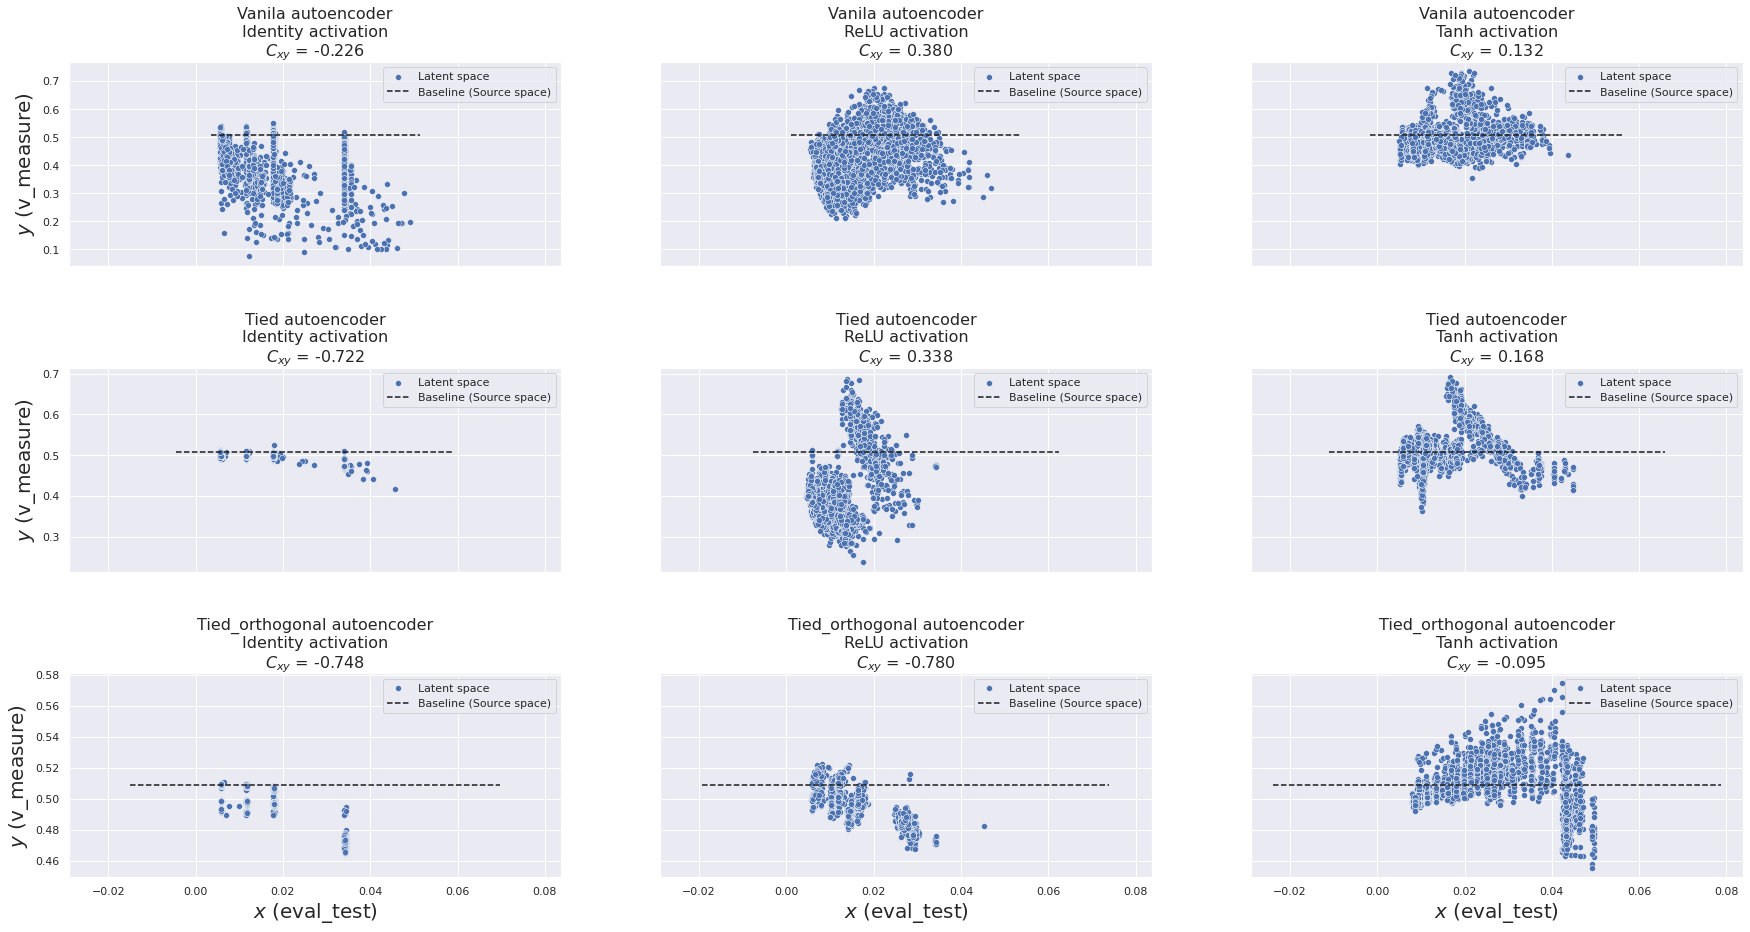

In [8]:
metrics = ["accuracy", "v_measure"]
factors = ["latent_dim", "rate_reduce", "num_layers", "epochs", "eval_test"]
for metric in metrics:
    for factor in factors:
        if factor == "rate_reduce":
            fig = scatter_plots(df[df.rate_reduce > 1], [factor, metric], baseline=baseline, corr_func=st.spearmanr)
        else:
            fig = scatter_plots(df, [factor, metric], baseline=baseline, corr_func=st.spearmanr)
        fig.savefig(f"Images/{metric}_{factor}.png")

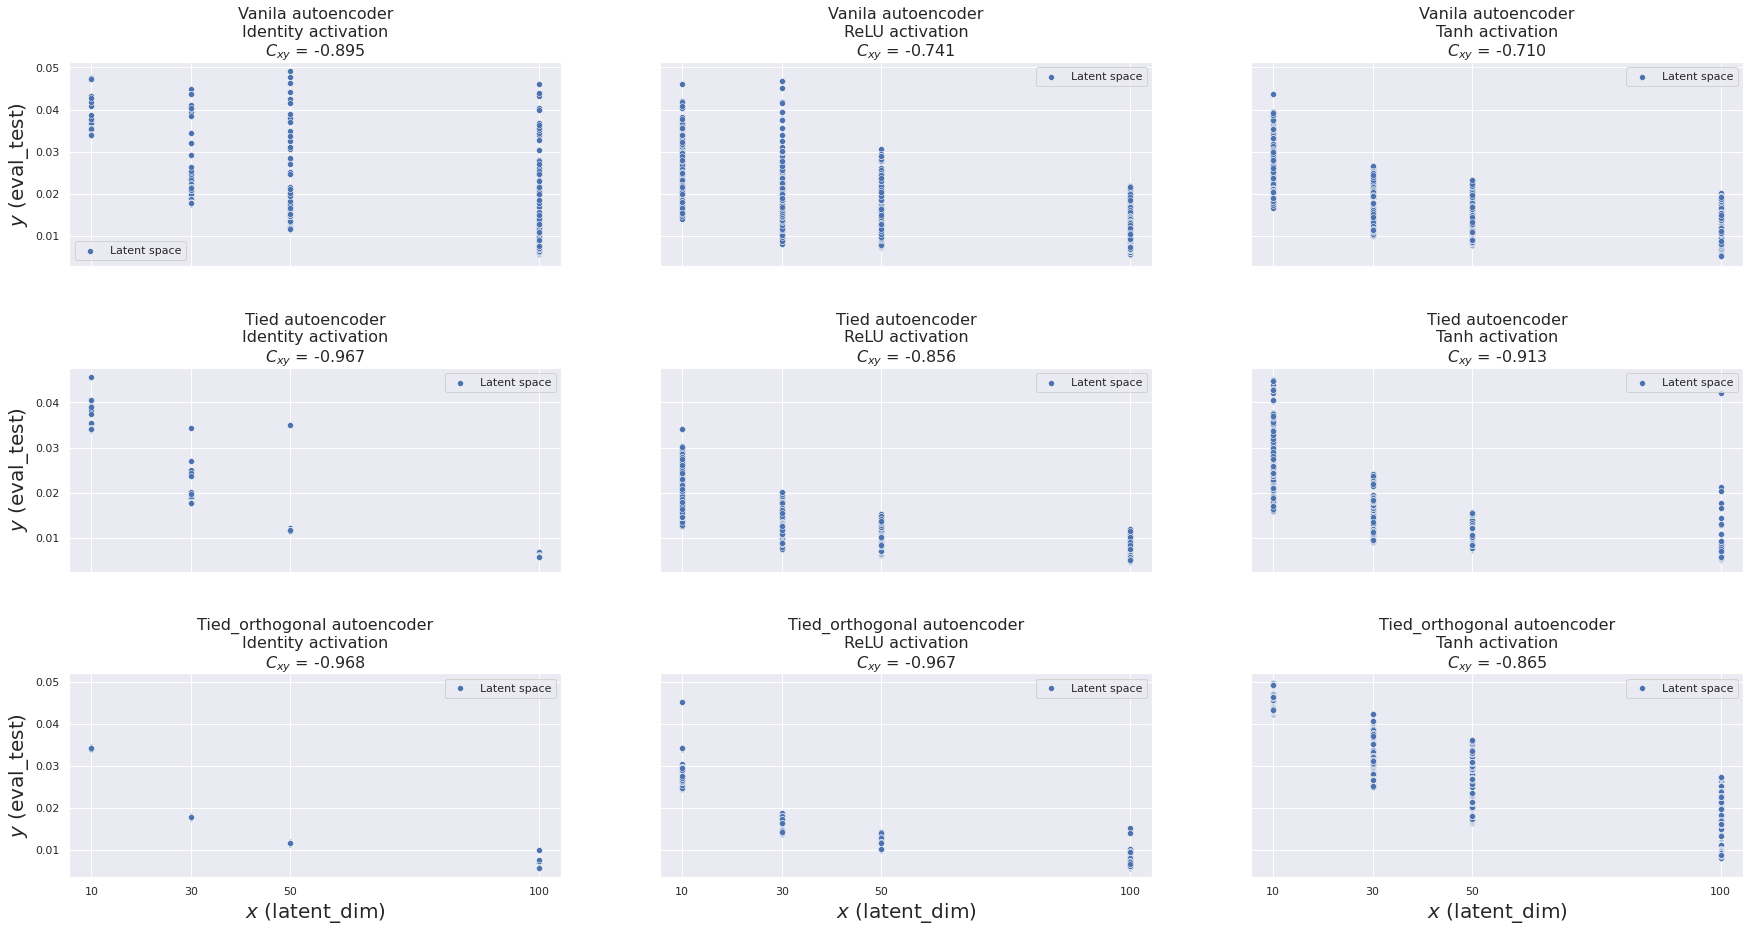

In [9]:
metrics = ["eval_test"]
factors = ["latent_dim"]
for metric in metrics:
    for factor in factors:
        fig = scatter_plots(df, [factor, metric], corr_func=st.spearmanr)
        fig.savefig(f"Images/{metric}_{factor}.png")

In [10]:
df["eval_test^2"] = df.eval_test**2
df["ln(latent_dim)"] = np.log(df.latent_dim)

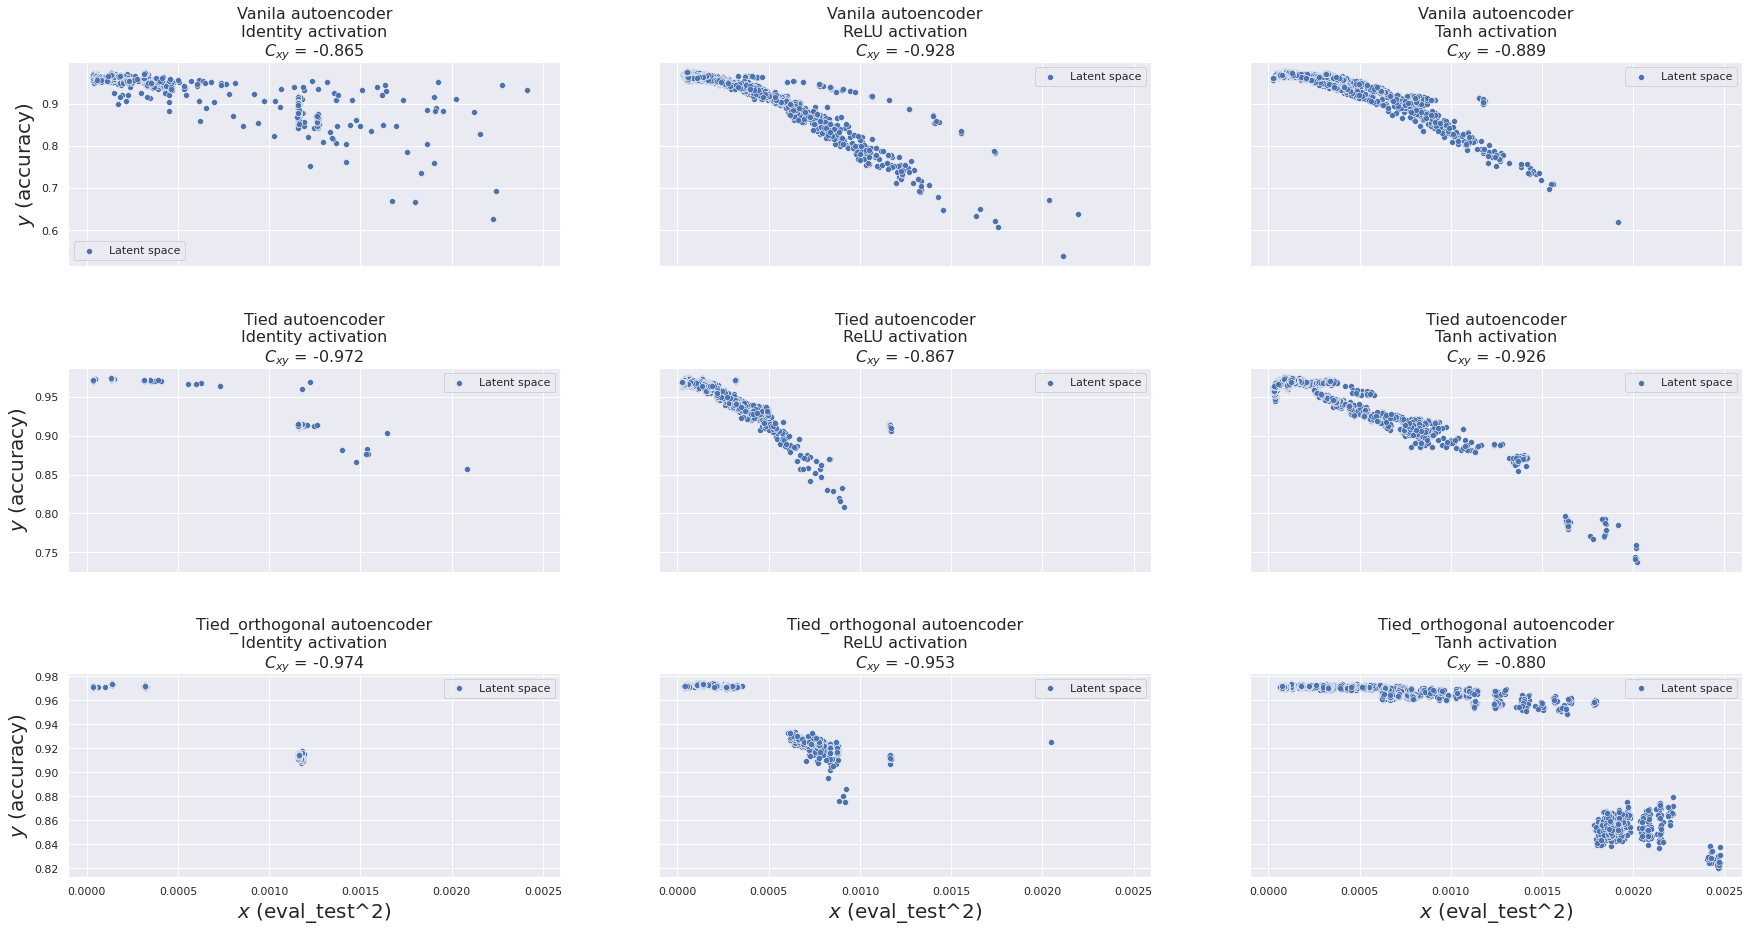

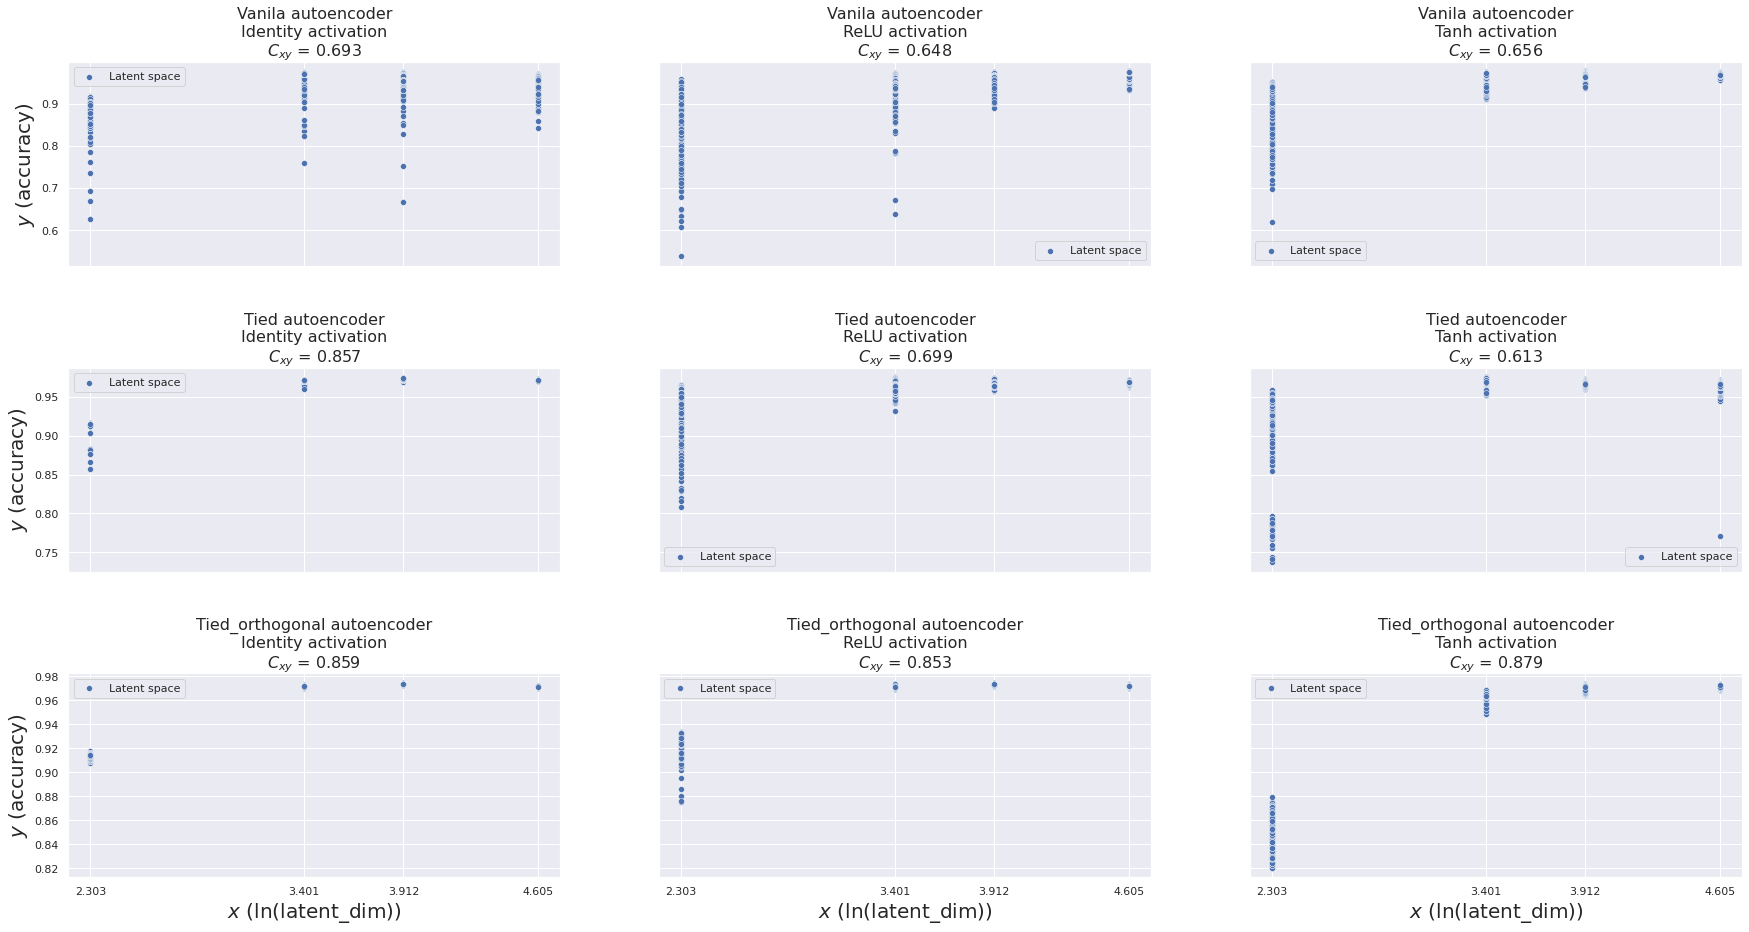

In [11]:
metrics = ["accuracy"]
factors = ["eval_test^2", "ln(latent_dim)"]
for metric in metrics:
    for factor in factors:
        fig = scatter_plots(df, [factor, metric], corr_func=st.pearsonr)
        fig.savefig(f"Images/{metric}_{factor}.png")

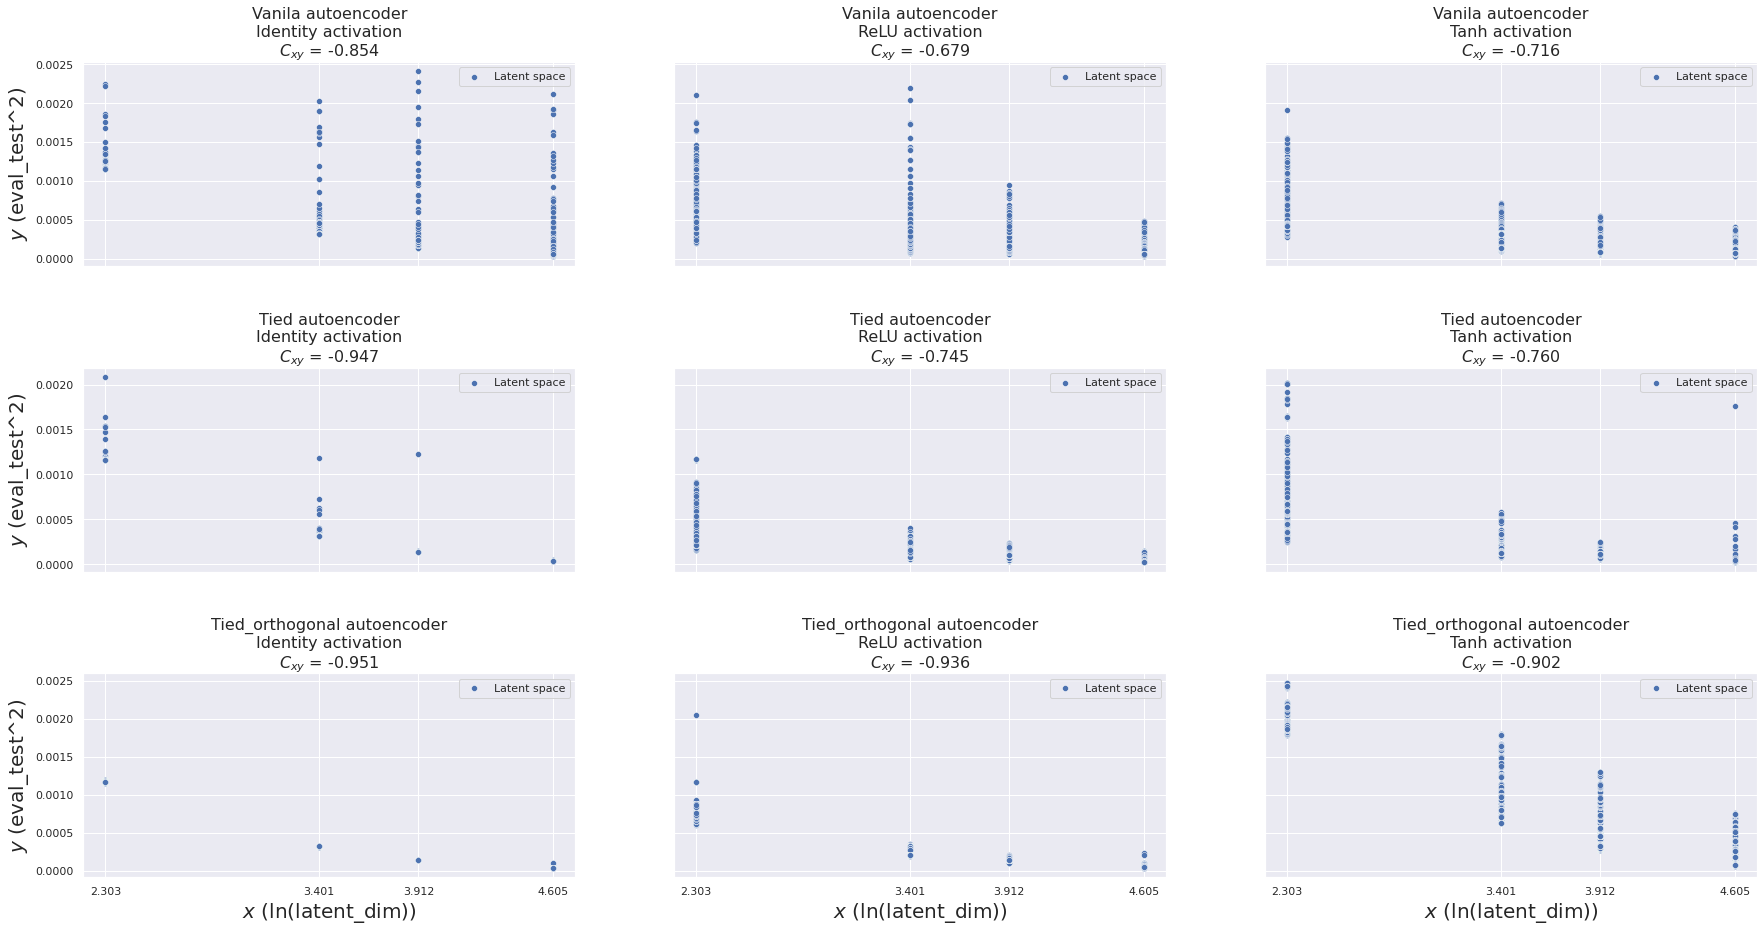

In [12]:
metrics = ["eval_test^2"]
factors = ["ln(latent_dim)"]
for metric in metrics:
    for factor in factors:
        fig = scatter_plots(df, [factor, metric], corr_func=st.pearsonr)
        fig.savefig(f"Images/{metric}_{factor}.png")

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [14]:
def adj_r2(model, X, y):
    return 1 - (1 - model.score(X, y)) * (len(X) - 1) / (len(X) - 1 - len(model.coef_))

In [15]:
df_res = []
cv = 10

for type_ae in df.type_ae.unique():
    for activation in df.activation.unique():
        tmp = df[(df.type_ae == type_ae) & (df.activation == activation)]
        Y = tmp.accuracy
        X = tmp[["eval_test^2", "ln(latent_dim)"]]
        inds = X.index.values
        np.random.shuffle(inds)
        X = X.loc[inds]
        for features in [["eval_test^2"], ["ln(latent_dim)"], ["eval_test^2", "ln(latent_dim)"]]:
            cv_res = cross_val_score(LinearRegression(), X[features], Y, cv=cv, scoring=adj_r2)
            df_res.append([type_ae, activation, features, cv_res])
                
df_res = pd.DataFrame(df_res, columns=["type_ae", "activation", "features", "R_2"])

In [16]:
df_res["mean"] = df_res.R_2.apply(np.mean)

In [17]:
df_res

,type_ae,activation,features,R_2,mean
0,tied_ae,Tanh,[eval_test^2],"[0.6895479970937222, 0.8494445896655347, 0.742...",0.793303
1,tied_ae,Tanh,[ln(latent_dim)],"[0.05269240759159477, 0.4116633169968069, 0.48...",0.365722
2,tied_ae,Tanh,"[eval_test^2, ln(latent_dim)]","[0.742174068996722, 0.8160237753333702, 0.7957...",0.814140
3,tied_ae,Identity,[eval_test^2],"[0.8981798320986848, 0.8247120745886729, 0.963...",0.905657
4,tied_ae,Identity,[ln(latent_dim)],"[0.5085015297506462, 0.2382307509307583, 0.783...",0.583897
5,tied_ae,Identity,"[eval_test^2, ln(latent_dim)]","[0.990422814419251, 0.9783121719459452, 0.9950...",0.970285
6,tied_ae,ReLU,[eval_test^2],"[0.8976467711440994, 0.890084789428711, 0.6899...",0.686012
7,tied_ae,ReLU,[ln(latent_dim)],"[0.5913331127466555, 0.3453081275743165, 0.286...",0.453766
8,tied_ae,ReLU,"[eval_test^2, ln(latent_dim)]","[0.8913682394231518, 0.888814665533581, 0.6808...",0.683121
9,tied_orthogonal_ae,Tanh,[eval_test^2],"[0.774611453715266, 0.6800799706054999, 0.8314...",0.762793


In [18]:
stats_res = []
alpha = 0.05 / 9
for type_ae in df_res.type_ae.unique():
    for activation in df_res.activation.unique():
        tmp = df_res[(df_res.type_ae == type_ae) & (df_res.activation == activation)]
        x = tmp[tmp.features.astype("str") == "['eval_test^2', 'ln(latent_dim)']"].R_2.iloc[0]
        y = tmp[tmp.features.astype("str") == "['eval_test^2']"].R_2.iloc[0]
        w, p = st.wilcoxon(x, y, alternative="greater")
        stats_res.append([type_ae, activation, w, p, p < alpha])
stats_res = pd.DataFrame(stats_res, columns=["type_ae", "activation", "w", "p", "reject_H0"])

In [19]:
stats_res

,type_ae,activation,w,p,reject_H0
0,tied_ae,Tanh,48.0,0.018555,False
1,tied_ae,Identity,54.0,0.001953,True
2,tied_ae,ReLU,21.0,0.753906,False
3,tied_orthogonal_ae,Tanh,43.0,0.065430,False
4,tied_orthogonal_ae,Identity,55.0,0.000977,True
5,tied_orthogonal_ae,ReLU,38.0,0.161133,False
6,vanila_ae,Tanh,22.0,0.721680,False
7,vanila_ae,Identity,32.0,0.347656,False
8,vanila_ae,ReLU,8.0,0.981445,False
